<a href="https://colab.research.google.com/github/DenisGubanov/Coursework-online-school-of-generations/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключение библиотек

В данном коде происходит подключение различных библиотек, которые будут использоваться в дальнейшем для работы с данными, построения графиков, обучения моделей и других операций.

In [82]:
# pip install инструментов.

flag = True
if (flag):

  # Установка mplfinance для построения графиков.
  !pip install mplfinance

  # Установка pmdarima для прогнозирования временных рядов.
  !pip install pmdarima

  # Установка ta для технического анализа финансовых данных.
  !pip install ta

In [83]:
# Подключение библиотек

# Работа с математическим инструментом
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random

# Работа с фин. моделями
import ta

# Построение графиков
import matplotlib.pyplot as plt
import mplfinance as mpf

# Работа с датами и временем
from datetime import datetime, timedelta
import datetime

# Инструменты ML
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, Dropout, LSTM, Dense, Flatten, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2

from scipy.interpolate import interp1d

# Дополнительные инструменты
import warnings
warnings.filterwarnings('ignore')

# Добавление основных меток

Функция `append_price` предназначена для добавления основных меток к дневным котировкам. Она выполняет предобработку данных и преобразует столбцы даты, цены, открытия, наивысшей и наименьшей цены, объема и изменения в нужный формат.

In [84]:
# Добавляем к основные метки
def append_price(path):

  # Предобработка
  df = pd.read_csv(path)
  col_ = ['date', 'price', 'open', 'high', 'low', 'vol', 'change']
  df.columns = col_
  df = df.iloc[::-1].reset_index(drop=True)
  df['date'] = pd.to_datetime(df['date'])

  # Основные метки ориентации девного бара
  for i in range(len(df)):
    df['price'][i] = float(str(df['price'][i]).replace(',', ''))
    df['open'][i] = float(str(df['open'][i]).replace(',', ''))
    df['high'][i] = float(str(df['high'][i]).replace(',', ''))
    df['low'][i] = float(str(df['low'][i]).replace(',', ''))
    df['change'][i] = float(str(df['change'][i]).replace('%', ''))
    df['vol'][i] = float(str(df['vol'][i]).replace('K', '').replace('M', '').replace('B', ''))

  # Заполнение пробелов для vol - случается редко...
  df['vol'] = df['vol'].fillna(1.0)

  return df

In [85]:
# Функция добавляющая данные ориентации бара на дневном, недельном, месячном и годовом баре
# Первые 30 дней не несут полезную нагрузку
def append_bar_orientation(df):

  # size
  df['size_high'] = df['high'] - df[['open', 'price']].max(axis=1)
  df['size_low'] = df[['open', 'price']].min(axis=1) - df['low']
  df['size_body'] = abs(df['price'] - df['open'])
  SIZE_TIMEFRAME = [['week', 7], ['month', 30]]
  for TIMEFRAME in SIZE_TIMEFRAME:
    df[f'size_body_{TIMEFRAME[0]}'] = 0
    for i in range(TIMEFRAME[1], len(df)):
      df[f'size_body_{TIMEFRAME[0]}'][i] = abs(df['price'][i] - df['open'][i - TIMEFRAME[1]])
    df[f'size_body_{TIMEFRAME[0]}'] = df[f'size_body_{TIMEFRAME[0]}'].fillna(df[f'size_body_{TIMEFRAME[0]}'][TIMEFRAME[1]])

  # volatility
  VOLATILITY_TIMEFRAME = [['week', 7], ['month', 30]]
  df['volatility_day'] = df['high'] - df['low'] + 1
  for TIMEFRAME in VOLATILITY_TIMEFRAME:
      df[f'volatility_{TIMEFRAME[0]}'] = df['high'].rolling(window=TIMEFRAME[1]).max() - df['low'].rolling(window=TIMEFRAME[1]).min()

  # ratio
  df['ratio_high'] = ((df['size_high'] / df['volatility_day']) * 100) / 100
  df['ratio_low'] = ((df['size_low'] / df['volatility_day']) * 100) / 100
  df['ratio_body'] = ((df['size_body'] / df['volatility_day']) * 100) / 100
  for i in range(len(df)):
    df['ratio_high'][i] = int(df['ratio_high'][i] * 100) / 100
    df['ratio_low'][i] = int(df['ratio_low'][i] * 100) / 100
    df['ratio_body'][i] = int(df['ratio_body'][i] * 100) / 100

  # bool count
  BOOL_PRICE_TIMEFRAME = [['week', 7], ['month', 30]]
  df['bool_day_price'] = df['price'] > df['open']
  for i in range(len(df)):
    df['bool_day_price'][i] = 1.0 if df['bool_day_price'][i] == True else -1.0
  for TIMEFRAME in BOOL_PRICE_TIMEFRAME:
    df[f'bool_{TIMEFRAME[0]}_price'] = 0
    for i in range(TIMEFRAME[1]-1, len(df[f'bool_{TIMEFRAME[0]}_price'])):
      c = 0
      for j in range(TIMEFRAME[1]):
        c += df[f'bool_day_price'][i-j]
      df[f'bool_{TIMEFRAME[0]}_price'][i] = c
    for i in range(TIMEFRAME[1]-1):
      df[f'bool_{TIMEFRAME[0]}_price'][i] = df[f'bool_{TIMEFRAME[0]}_price'][2*TIMEFRAME[1]-i]

  # average
  AVERAGE_PRICE_TIMEFRAME = [['week', 7, 7], ['month', 30, 2]]
  df['average_day_price'] = (df['high'] + df['low']) / 2
  for TIMEFRAME in AVERAGE_PRICE_TIMEFRAME:
    df[f'average_{TIMEFRAME[0]}_price'] = 0
    for i in range(TIMEFRAME[1]-1, len(df[f'average_{TIMEFRAME[0]}_price'])):
      c = 0
      for j in range(TIMEFRAME[1]):
        c += df['average_day_price'][i-j]
      df[f'average_{TIMEFRAME[0]}_price'][i] = c / TIMEFRAME[1]
    for i in range(TIMEFRAME[1]-1):
      df[f'average_{TIMEFRAME[0]}_price'][i] = df[f'average_{TIMEFRAME[0]}_price'][TIMEFRAME[1]-1] - (TIMEFRAME[1]*TIMEFRAME[2]-i*TIMEFRAME[2])
    for i in range(len(df)):
      df[f'average_{TIMEFRAME[0]}_price'][i] = int(df[f'average_{TIMEFRAME[0]}_price'][i] * 100) / 100

  # price change
  PRICE_CHANGE_TIMEFRAME = [['week', 7], ['month', 30]]
  for TIMEFRAME in PRICE_CHANGE_TIMEFRAME:
      column_name = f'price_change_{TIMEFRAME[0]}_p'
      df[column_name] = (df['price'] - df['price'].shift(TIMEFRAME[1])) / df['price'].shift(TIMEFRAME[1]) * 100
      for i in range(TIMEFRAME[1]):
        df[column_name][i] = int(df[column_name][TIMEFRAME[1]] - (TIMEFRAME[1] - i)*0.01)
      for i in range(len(df)):
        df[column_name][i] = int(df[column_name][TIMEFRAME[1]] - (TIMEFRAME[1] - i)* 100) / 100
      column_name = f'price_change_{TIMEFRAME[0]}'
      df[column_name] = (df['price'] - df['price'].shift(TIMEFRAME[1]))
      for i in range(TIMEFRAME[1]):
        df[column_name][i] = int(df[column_name][TIMEFRAME[1]] - (TIMEFRAME[1] - i)*0.01)
      for i in range(len(df)):
        df[column_name][i] = int(df[column_name][TIMEFRAME[1]] - (TIMEFRAME[1] - i)* 100) / 100

  df.set_index('date', inplace=True)
  return df

# Описание функции `append_rsi`

Данная функция выполняет добавление индикатора RSI (Индекс относительной силы) к столбцу `price` фрейма данных (`df`).

In [86]:
# в rsi используется 14 ненужных дней их мы тоже удалим
def append_rsi(df):
    for i in range(len(df)):
        df['price'][i] = float(str(df['price'][i]).replace(',', ''))

    rsi_indicator = ta.momentum.RSIIndicator(df['price'], window=14)
    df['rsi'] = rsi_indicator.rsi()
    df['stoch_rsi'] = (df['rsi'] - rsi_indicator.rsi().rolling(window=14).min()) / (rsi_indicator.rsi().rolling(window=14).max() - rsi_indicator.rsi().rolling(window=14).min())

    save = 45
    for i in range(14):
        df['rsi'][i] = save - 1
        df['stoch_rsi'][i] = save - 2
        save -= 1

    for i in range(len(df)):
        df['rsi'][i] = int(df['rsi'][i] * 10) / 10

    # Добавление столбца signal_line_comparison для стохастического RSI
    df['stoch_rsi_signal'] = df['stoch_rsi'].rolling(window=3).mean()
    df['stoch_rsi_comparison'] = np.where(df['stoch_rsi_signal'] > df['stoch_rsi'], 1, -1)

    for i in range(len(df)):
      if (np.isnan(df['stoch_rsi'][i]) == True):
        df['stoch_rsi'][i] = df['stoch_rsi'][i-1] + 1
      if (np.isnan(df['stoch_rsi_signal'][i]) == True):
        df['stoch_rsi_signal'][i] = df['stoch_rsi_signal'][i-1] + 1
      df['rsi'][i] = int(df['rsi'][i] * 100) / 100
      df['stoch_rsi_signal'][i] = int(df['stoch_rsi_signal'][i] * 100) / 100
      df['stoch_rsi'][i] = int(df['stoch_rsi'][i] * 100) / 100

    # Добавление столбца High_rsi
    df['high_rsi'] = np.where(df['rsi'] < 70, 0, 1)

    # Добавление столбца Low_rsi
    df['low_rsi'] = np.where(df['rsi'] > 30, 0, 1)

    # Добавление столбца Low_rsi
    df['mid_rsi'] = np.where(df['rsi'] > 50, 1, -1)

    return df

# Описание функции `append_macd`

Данная функция выполняет добавление индикатора MACD (Moving Average Convergence Divergence) к столбцу `price` фрейма данных (`df`).

In [87]:
# 26 дней на macd можно убрать лишняя информация
def append_macd(df):
    macd_period_slow = 26
    macd_period_fast = 12
    macd_period_signal = 9
    macd = ta.trend.MACD(df['price'], window_slow=macd_period_slow, window_fast=macd_period_fast, window_sign=macd_period_signal)
    df['macd_slow'] = macd.macd_signal()
    df['macd_fast'] = macd.macd_diff()
    df['macd_signal'] = macd.macd()

    # Заполнение пробелов - необязательно далее удаляется
    save = 16
    for i in range(macd_period_slow):
        df['macd_slow'][i] = save - 1
        df['macd_fast'][i] = save - 2
        df['macd_signal'][i] = save - 3
        save -= 0.1

    # Добавление столбца signal_line_comparison
    df['signal_line_comparison'] = np.where(df['macd_signal'] > df['macd_slow'], 1, -1)
    for i in range(len(df)):
      if (np.isnan(df['macd_slow'][i])== True):
        df['macd_slow'][i] = df['macd_slow'][i-1] + 1
      if (np.isnan(df['macd_fast'][i]) == True):
        df['macd_fast'][i] = df['macd_fast'][i-1] + 1
      df['macd_slow'][i] = int(df['macd_slow'][i] * 100) / 100
      df['macd_fast'][i] = int(df['macd_fast'][i] * 100) / 100
      df['macd_signal'][i] = int(df['macd_signal'][i] * 100) / 100

    return df


# Описание функции `append_ma`

Данная функция выполняет добавление индикатора MA (Moving Average) к столбцу `price` фрейма данных (`df`).

In [88]:
# Добавляем к df['price'] индикатор ma
def append_ma(df):

  # Максимум 30 ненужных дней
  for period in [7, 14, 21, 30]:
    df[f'sma_{period}'] = ta.trend.sma_indicator(df['price'], window=period)
    save = df[f'sma_{period}'][period]
    for i in range(period, -1, -1):
      df[f'sma_{period}'][period - i] = save - (i*5)
    for i in range(len(df)):
      df[f'sma_{period}'][i] = int(df[f'sma_{period}'][i] * 10) / 10

  # Максимум 30 ненужных дней
  for period in [7, 14, 21, 30]:
    df[f'ema_{period}'] = ta.trend.ema_indicator(df['price'], window=period)
    save = df[f'ema_{period}'][period]
    for i in range(period, -1, -1):
      df[f'ema_{period}'][period - i] = save - (i*5)
    for i in range(len(df)):
      df[f'ema_{period}'][i] = int(df[f'ema_{period}'][i] * 10) / 10

  # TrueLine - индикатор
  vma = ta.trend.wma_indicator(df['price'], window=21)

  # Рассчитываем уровни 0.618, 0.5 и 0.382 от VWMA
  df['true_line_l1'] = vma * 0.618
  df['true_line_l2'] = vma * 0.5
  df['true_line_l3'] = vma * 0.382

  # Расчёт дельты
  df['true_line_delta_l1'] = df['price'] - df['true_line_l1']
  df['true_line_delta_l2'] = df['price'] - df['true_line_l2']
  df['true_line_delta_l3'] = df['price'] - df['true_line_l3']

  return df

# Описание функции `append_bb`

Данная функция выполняет добавление индикатора Bollinger Bands (BB) к столбцу `price` фрейма данных (`df`).



In [89]:
# Добавляем к df['price'] индикатор bb
# Ненужных дней остатется 20 в BB индикаторе
def append_bb(df):
    bollinger_period = 20
    bollinger_std = 2
    df['bb_middle'] = ta.volatility.bollinger_mavg(df['price'], window=bollinger_period)
    df['bb_upper'] = df['bb_middle'] + bollinger_std * df['price'].rolling(window=bollinger_period).std()
    df['bb_lower'] = df['bb_middle'] - bollinger_std * df['price'].rolling(window=bollinger_period).std()
    savem = df['bb_middle'][bollinger_period]
    saveu = df['bb_middle'][bollinger_period]
    savel = df['bb_middle'][bollinger_period]
    for i in range(bollinger_period, -1, -1):
      df['bb_middle'][bollinger_period - i] = savem - (i*5)
      df['bb_upper'][bollinger_period - i] = saveu - (i*5)
      df['bb_lower'][bollinger_period - i] = savel - (i*5)
    for i in range(len(df)):
      df['bb_middle'][i] = int(df['bb_middle'][i] * 10) / 10
      df['bb_upper'][i] = int(df['bb_upper'][i] * 10) / 10
      df['bb_lower'][i] = int(df['bb_lower'][i] * 10) / 10
    df['bb_width'] = df['bb_upper'] - df['bb_lower']
    return df

# Описание функции `append_stoch_oscillator`

Данная функция выполняет добавление индикатора Stochastic Oscillator к столбцу `price` фрейма данных (`df`).


In [90]:
# Добавляем к df['price'] индикатор stoch osc
# Ненужных 14 строк
def append_stoch_oscillator(df):
    stoch_period = 14
    stoch = ta.momentum.StochasticOscillator(df['high'], df['low'], df['price'], window=stoch_period)
    df['stoch_oscillator'] = stoch.stoch()
    sto = df['stoch_oscillator'][stoch_period]
    for i in range(stoch_period, -1, -1):
      df['stoch_oscillator'][stoch_period - i] = sto - (i*2)
    for i in range(len(df)):
      df['stoch_oscillator'][i] = int(df['stoch_oscillator'][i] * 10) / 10
    return df

# Описание функции `append_rvi`

Функция волатильности

In [106]:
import pandas as pd
import numpy as np

def append_rvi(df, period=14):
    close_prices = df['price']
    open_prices = df['open']

    high_close_diff = abs(close_prices - open_prices)
    low_close_diff = abs(close_prices - df['low'])

    positive_oscillator = (high_close_diff > low_close_diff).astype(int)
    negative_oscillator = (high_close_diff < low_close_diff).astype(int)

    positive_oscillator_sma = positive_oscillator.rolling(window=period, min_periods=1).mean()
    negative_oscillator_sma = negative_oscillator.rolling(window=period, min_periods=1).mean()

    rvi = (positive_oscillator_sma / (positive_oscillator_sma + negative_oscillator_sma)) * 100
    df['rvi'] = rvi
    df['rvi_high'] = np.where(df['rvi'] > 80, 1, -1)
    df['rvi_middle'] = np.where(df['rvi'] > 50, 1, -1)
    df['rvi_low'] = np.where(df['rvi'] < 20, 1, -1)
    return df


# Используется для подключения данных `append_ticker`

Данная функция `append_ticker` используется для подключения данных с других инструментов и добавления их в существующий DataFrame.

In [92]:
# Подключение данных с других инструментов
def append_ticker(df, path, ticker, price_float = False):
    temp = pd.read_csv(path)
    temp['Date'] = pd.to_datetime(temp['Date'])
    temp = temp[['Date', 'Price', 'Change %']]
    temp.columns = ['date', f'{ticker}_price', f'{ticker}_change']
    if (price_float == False):
      temp[f'{ticker}_price'] = temp[f'{ticker}_price'].apply(lambda x: float(x.replace(',', '')))
    temp[f'{ticker}_change'] = temp[f'{ticker}_change'].apply(lambda x: float(x.replace('%', '')))
    df = df.merge(temp, on='date', how='left')

    # Заполнение пропущенных значений на предыдущем шаге
    df[f'{ticker}_price'].fillna(method='ffill', inplace=True)
    df[f'{ticker}_change'].fillna(method='ffill', inplace=True)

    df = df.fillna(0)
    df.index = df['date']
    df = df.drop(['date'], axis=1)

    for i in range(len(df)):
        df[f'{ticker}_price'][i] = float(str(df[f'{ticker}_price'][i]).replace(',', ''))

    rsi_indicator = ta.momentum.RSIIndicator(df[f'{ticker}_price'], window=14)
    df[f'{ticker}_rsi'] = rsi_indicator.rsi()

    save = 45
    for i in range(14):
        df[f'{ticker}_rsi'][i] = save - 1
        save -= 1

    for i in range(len(df)):
        df[f'{ticker}_rsi'][i] = int(df[f'{ticker}_rsi'][i] * 10) / 10

    df = df.fillna(0)

    return df

# Индикатор халвинга

Данная функция `append_halving` используется для добавления индикатора халвинга в существующий DataFrame.

In [93]:
# Индикатор халвинга
def append_halving(df):
    df['date'] = pd.to_datetime(df.index)
    halving_dates = [datetime.datetime(2012, 11, 28), datetime.datetime(2016, 7, 9), datetime.datetime(2020, 5, 11)]
    df['halving'] = 0
    c = 541
    for i in range(len(df)):
        df['halving'][i] = c
        if df.index[i] in halving_dates:
          c = 0
        else:
          c += 1
    df = df.drop(['date'], axis=1)
    return df

## Индикатор KDJ - трендовый
Данная функция `append_kdj` используется для добавления трендового индикатора KDJ в существующий DataFrame.

In [94]:
# Индикатор KDJ - трендовый
def bcwsma(s, l, m):
    _s = s
    _l = l
    _m = m
    _bcwsma = np.zeros(len(_s))
    _bcwsma[0] = _s[0]
    for i in range(1, len(_s)):
        if np.isnan(_bcwsma[i-1]):
            _bcwsma[i] = 1
        else:
            _bcwsma[i] = (_m * _s[i] + (_l - _m) * _bcwsma[i-1]) / _l
    return _bcwsma

# Основная функция
def append_kdj(df):

    # Интервал
    ilong = 9
    isig = 3

    # Логика индикатора KDJ
    c = df['price']
    h = df['high'].rolling(window=ilong).max()
    l = df['low'].rolling(window=ilong).min()
    RSV = 100 * ((c - l) / (h - l))
    pK = bcwsma(RSV, isig, 1)
    pD = bcwsma(pK, isig, 1)
    pJ = 3 * pK - 2 * pD

    # Создание меток
    df['k_indicator_kdj'] = pK
    df['d_indicator_kdj'] = pD
    df['j_indicator_kdj'] = pJ

    # Заполнение пробелов в начале
    df['k_indicator_kdj'] = df['k_indicator_kdj'].fillna(1.0)
    df['d_indicator_kdj'] = df['d_indicator_kdj'].fillna(1.0)
    df['j_indicator_kdj'] = df['j_indicator_kdj'].fillna(1.0)

    for i in range(len(df)):
      df['k_indicator_kdj'][i] = int(df['k_indicator_kdj'][i] * 10) / 10
      df['d_indicator_kdj'][i] = int(df['d_indicator_kdj'][i] * 10) / 10
      df['j_indicator_kdj'][i] = int(df['j_indicator_kdj'][i] * 10) / 10

    df['red_green_indicator_kdj'] = np.where(pJ > pD, 1, -1)

    return df

# Расчет индикатора `Parabolic SAR`

Функция append_parabolic_sar выполняет расчет индикатора Parabolic SAR на основе данных, содержащихся в DataFrame df. Индикатор Parabolic SAR используется для определения точек разворота тренда на рынке.

In [95]:
# SAR имеет нулевое отклонение на дне
def append_parabolic_sar(df):
    acceleration=0.02
    max_acceleration=0.2
    trend = 1
    ep = df['low'].iloc[0] if trend > 0 else df['high'].iloc[0]
    af = acceleration
    sar_values = []
    for i in range(len(df)):
        sar_values.append(ep)

        if trend > 0:
            if df['low'].iloc[i] < ep:
                trend = -1
                sar_values[-1] = ep
                ep = df['high'].iloc[i]
                af = acceleration
            else:
                if df['high'].iloc[i] > ep:
                    ep = df['high'].iloc[i]
                    af = min(af + acceleration, max_acceleration)
        else:
            if df['high'].iloc[i] > ep:
                trend = 1
                sar_values[-1] = ep
                ep = df['low'].iloc[i]
                af = acceleration
            else:
                if df['low'].iloc[i] < ep:
                    ep = df['low'].iloc[i]
                    af = min(af + acceleration, max_acceleration)

        ep += af * (df['high'].iloc[i] if trend > 0 else df['low'].iloc[i] - ep)

    df[f'parabolic_sar'] = sar_values
    df[f'parabolic_sar_delta'] = df[f'parabolic_sar'] - df['price']
    df[f'parabolic_sar_trend'] = np.where(df['parabolic_sar'] < df['price'], 1, -1)
    return df

# Добавляет метку `On-Balance Volume (OBV)` к DataFrame.

Параметры:
  - df (pandas.DataFrame): Исходный DataFrame, к которому нужно добавить метку OBV.


In [96]:
# также имеет нулевое отклонение в начале. Заменять не надо
def append_obv_indicator(df):
    obv = [0]
    for i in range(1, len(df)):
        if df['price'].iloc[i] > df['price'].iloc[i-1]:
            obv.append(obv[i-1] + df['vol'].iloc[i])
        elif df['price'].iloc[i] < df['price'].iloc[i-1]:
            obv.append(obv[i-1] - df['vol'].iloc[i])
        else:
            obv.append(obv[i-1])
    df['obv_indicator'] = obv

    # Максимум 30 ненужных дней
    for period in [7, 14, 21, 30]:
      df[f'obv_sma_{period}'] = ta.trend.sma_indicator(df['obv_indicator'], window=period)
      save = df[f'obv_sma_{period}'][period]
      for i in range(period, -1, -1):
        df[f'obv_sma_{period}'][period - i] = save - (i*5)
      for i in range(len(df)):
        df[f'obv_sma_{period}'][i] = int(df[f'obv_sma_{period}'][i] * 10) / 10
    return df

# Добавляет метки `Average Directional Index` (ADX), `Positive` Directional Indicator (DI+), и `Negative` Directional Indicator (DI-) к DataFrame.

Параметры:
  - df (pandas.DataFrame): Исходный DataFrame, к которому нужно добавить метки ADX, DI+, и DI-.
  - window (int): Период окна для расчета ADX. По умолчанию равен 14.


In [108]:
# 14 дней в начале можно отбросить
def append_adx_indicator(df, window=14):

    # Расчет истинного диапазона (True Range)
    df['high_prev'] = df['high'].shift(1)
    df['low_prev'] = df['low'].shift(1)
    df['tr1'] = df['high'] - df['low']
    df['tr2'] = abs(df['high'] - df['high_prev'])
    df['tr3'] = abs(df['low'] - df['low_prev'])
    df['true_range'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)
    df.drop(['high_prev', 'low_prev', 'tr1', 'tr2', 'tr3'], axis=1, inplace=True)

    # Расчет плюсового и минусового направлений (Positive Directional Movement и Negative Directional Movement)
    df['up_move'] = df['high'] - df['high'].shift(1)
    df['down_move'] = df['low'].shift(1) - df['low']
    df['plus_dm'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
    df['minus_dm'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0)
    df.drop(['up_move', 'down_move'], axis=1, inplace=True)

    # Расчет Average True Range (ATR), True Range Moving Average (TRMA), Positive Directional Indicator (+DI), Negative Directional Indicator (-DI), и Average Directional Index (ADX)
    df['atr'] = df['true_range'].rolling(window).mean()
    df['trma'] = df['atr'].rolling(window).mean()
    df['plus_di'] = 100 * (df['plus_dm'].rolling(window).sum() / df['trma'])
    df['minus_di'] = 100 * (df['minus_dm'].rolling(window).sum() / df['trma'])
    df['adx'] = 100 * (abs(df['plus_di'] - df['minus_di']) / (df['plus_di'] + df['minus_di']))

    # Заполнение пропущенных значений в начале
    df['plus_di'].fillna(0, inplace=True)
    df['minus_di'].fillna(0, inplace=True)
    df['adx'].fillna(0, inplace=True)

    for i in range(len(df)):
      df['plus_di'][i] = int(df['plus_di'][i] * 10) / 10
      df['minus_di'][i] = int(df['minus_di'][i] * 10) / 10
      df['adx'][i] = int(df['adx'][i] * 10) / 10

    # Удаление временных столбцов
    df.drop(['true_range', 'atr', 'trma', 'plus_dm', 'minus_dm'], axis=1, inplace=True)

    return df

# Канал Гаусса

Распределение Гаусса — это статистическая концепция, также известная как нормальное распределение.

In [98]:
import numpy as np
import pandas as pd

# 20 дней выкидываем в начале

def append_gaussian_channel(df, window=20, width=2):
    rolling_mean = df['price'].rolling(window).mean()
    rolling_std = df['price'].rolling(window).std()
    upper_channel = rolling_mean + width * rolling_std
    lower_channel = rolling_mean - width * rolling_std

    df['upper_GC'] = upper_channel
    df['lower_GC'] = lower_channel

    # Определение направления движения Канала Гаусса
    df['up_down_GC'] = np.where(upper_channel > upper_channel.shift(), 1, -1)

    df = df.fillna(0)
    return df


# Моментум

Моментум в трейдинге - это скорость изменения цены инструмента за определенный промежуток времени

In [99]:
# 14 дней можно выкинуть из начала

def append_momentum(df, period=14):
    close_price = df['price']
    momentum = close_price.diff(period)
    df['momentum'] = momentum

    # Максимум 14 ненужных дней
    for period in [7, 14]:
      df[f'mom_sma_{period}'] = ta.trend.sma_indicator(df['momentum'], window=period)
      save = df[f'mom_sma_{period}'][period]
      for i in range(period, -1, -1):
        df[f'mom_sma_{period}'][period - i] = save - (i*5)
    return df

In [109]:
import pandas as pd

def append_mfi(df):
    typical_price = (df['high'] + df['low'] + df['price']) / 3
    raw_money_flow = typical_price * df['vol']
    positive_money_flow = (typical_price > typical_price.shift(1)) * raw_money_flow
    negative_money_flow = (typical_price < typical_price.shift(1)) * raw_money_flow

    # Calculate rolling sums
    positive_money_flow_sum = positive_money_flow.rolling(window=14, min_periods=1).sum()
    negative_money_flow_sum = negative_money_flow.rolling(window=14, min_periods=1).sum()

    # Calculate money flow ratio
    money_flow_ratio = positive_money_flow_sum / negative_money_flow_sum

    # Calculate MFI and labels
    df['mfi'] = 100 - (100 / (1 + money_flow_ratio))
    df['mfi_high'] = np.where(df['mfi'] > 80, 1, -1)
    df['mfi_middle'] = np.where(df['mfi'] > 50, 1, -1)
    df['mfi_low'] = np.where(df['mfi'] < 20, 1, -1)

    return df


# Формирование DataFrame

## Шаг 1: Загрузка данных
Используя функцию `append_price`, загружаются и предобрабатываются данные из файла 'BTC_USD Bitfinex Historical Data.csv', и результат сохраняется в переменной `btc_df`.

## Шаг 2: Добавление индикаторов
С помощью последовательного применения функций `append_rsi`, `append_macd`, `append_ma`, `append_bb`, `append_sto`, `append_atr` добавляются соответствующие индикаторы к фрейму данных `btc_df`.

## Шаг 3: Вывод данных
Выводятся первые 7 строк (`head()`) и последние 7 строк (`tail()`) фрейма данных `btc_df`, а также выводится размерность данных (`shape`).

In [135]:
import pandas as pd
import numpy as np

# Формируем DataFrame

# Образующие метки
btc_df = append_price('btc0.csv')
btc_df = append_bar_orientation(btc_df)

## Метки индикаторов

# Скользящие
btc_df = append_ma(btc_df)

# Базовые основанные на ma
btc_df = append_rsi(btc_df)
btc_df = append_macd(btc_df)
btc_df = append_stoch_oscillator(btc_df)

# Каналы
btc_df = append_bb(btc_df)
btc_df = append_gaussian_channel(btc_df)

# Трендовые индикторы
btc_df = append_kdj(btc_df)
btc_df = append_parabolic_sar(btc_df)
btc_df = append_adx_indicator(btc_df)

# Стратегии
btc_df = append_momentum(btc_df)
btc_df = append_obv_indicator(btc_df)
#btc_df = append_mfi(btc_df)

# Ончейн
btc_df = append_halving(btc_df)

# Индикаторы волотильности
#btc_df = append_rvi(btc_df) # Ужасно портит прогноз

# Метри дополнительных инструментов
#btc_df = append_ticker(btc_df, 'ETH_USD Binance Historical Data.csv', 'eth')
#btc_df = append_ticker(btc_df, 'ethbtc1.csv', 'ethbtc', price_float = True)
#btc_df = append_ticker(btc_df, 'SQ Historical Data.csv', 'sq', price_float = True)

#btc_df.index = btc_df['date']
#btc_df = btc_df.drop(['date'], axis=1)

btc_df = btc_df[30:]

print(btc_df.isna().sum().sum())

# head()
print('Данные head():')
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.width', None)  # Установить ширину вывода без ограничений
print(btc_df.head(7).to_string(col_space=12))

# tail()
print('Данные tail():')
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.width', None)  # Установить ширину вывода без ограничений
print(btc_df.tail(7).to_string(col_space=12))

# shape
print('Данные shape:')
print(btc_df.shape, end='\n\n')

0
Данные head():
                    price         open         high          low          vol       change    size_high     size_low    size_body  size_body_week  size_body_month  volatility_day  volatility_week  volatility_month   ratio_high    ratio_low   ratio_body  bool_day_price  bool_week_price  bool_month_price  average_day_price  average_week_price  average_month_price  price_change_week_p  price_change_week  price_change_month_p  price_change_month        sma_7       sma_14       sma_21       sma_30        ema_7       ema_14       ema_21       ema_30  true_line_l1  true_line_l2  true_line_l3  true_line_delta_l1  true_line_delta_l2  true_line_delta_l3          rsi    stoch_rsi  stoch_rsi_signal  stoch_rsi_comparison     high_rsi      low_rsi      mid_rsi    macd_slow    macd_fast  macd_signal  signal_line_comparison  stoch_oscillator    bb_middle     bb_upper     bb_lower     bb_width     upper_GC     lower_GC   up_down_GC  k_indicator_kdj  d_indicator_kdj  j_indicator_kdj  re

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from keras.layers import Bidirectional, LSTM, Dense, concatenate, Attention, BatchNormalization
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Загрузка данных
df = btc_df

# Разделение данных на признаки (X) и метки (y)
X = df # Удаление столбцов, которые не нужно предсказывать
y = df # Оставляем только столбцы, которые нужно предсказывать

# Масштабирование данных
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.transform(y)

# Преобразование данных в последовательности
def create_sequences(X, y, n_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i:i+n_steps])
        y_seq.append(y[i+n_steps])
    return np.array(X_seq), np.array(y_seq)

future_y_pred_scaled = []

In [139]:
# Гиперпараметры
n_steps = 30
n_future_steps = 30
depth_LSTM = 256
depth_DENSE = [8, 4, 2]
epochs = 1000
batch_size = 32
learning_rate = 0.001

# Создание последовательностей для обучения
X_seq, y_seq = create_sequences(X_scaled, y_scaled, n_steps)

# Разделение данных на обучающий и тестовый наборы
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# Создание и обучение модели LSTM
model = Sequential()
model.add(LSTM(units=depth_LSTM, activation='relu', input_shape=(n_steps, X.shape[1]),
               kernel_regularizer=regularizers.l2(0.01),
               recurrent_regularizer=regularizers.l2(0.01),
               bias_regularizer=regularizers.l2(0.01)))
model.add(Dense(depth_DENSE[0] * y.shape[1], kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Dense(depth_DENSE[1] * y.shape[1], kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Dense(depth_DENSE[2] * y.shape[1], kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Dense(y.shape[1], kernel_regularizer=regularizers.l2(0.01), activation='linear'))

# Компиляция модели с оптимизатором Adam и learning rate
optimizer = Adam(learning_rate=learning_rate)
early_stopping = EarlyStopping(patience=6, monitor='val_loss', mode='min')
model.compile(optimizer=optimizer, loss='mae')
model.summary()
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], validation_data=(X_test, y_test))

# Прогнозирование на тестовом наборе
y_pred = model.predict(X_test)

# Обратное масштабирование предсказанных значений
y_pred_scaled = scaler.inverse_transform(y_pred)
y_test_scaled = scaler.inverse_transform(y_test)

# Создание последовательности для прогнозирования
future_dates = pd.date_range(start=df.index[-1], periods=n_future_steps, freq='D')
future_X = X_scaled[-n_steps:].reshape(1, n_steps, X_scaled.shape[1])
future_y_pred = []

# Генерация прогноза
for _ in range(n_future_steps):
    future_y = model.predict(future_X)[0]
    future_y_pred.append(future_y)
    future_X = np.concatenate([future_X[:, 1:, :], future_y.reshape(1, 1, y_scaled.shape[1])], axis=1)

# Обратное масштабирование предсказанных значений
future_y_pred_scaled_1 = scaler.inverse_transform(future_y_pred)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 256)               344064    
                                                                 
 dense_81 (Dense)            (None, 632)               162424    
                                                                 
 dense_82 (Dense)            (None, 316)               200028    
                                                                 
 dense_83 (Dense)            (None, 158)               50086     
                                                                 
 dense_84 (Dense)            (None, 79)                12561     
                                                                 
Total params: 769,163
Trainable params: 769,163
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
26/26 [===========================

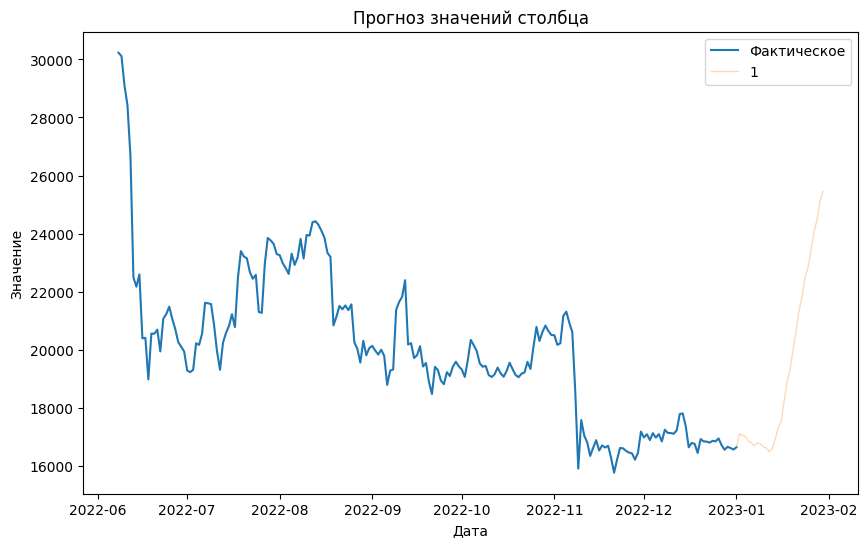

In [140]:
w__ = [1, 1, 1, 1, 1, 1]
y__ = w__[0]*future_y_pred_scaled_1 #(w__[0]*future_y_pred_scaled_1 + w__[1]*future_y_pred_scaled_2 + w__[2]*future_y_pred_scaled_3 + w__[3]*future_y_pred_scaled_4 + w__[4]*future_y_pred_scaled_5 + w__[5]*future_y_pred_scaled_6) / sum(w__)
def coef_scale(y__):
  i = 0
  for i in range(-100000, 100000):
    if (abs(y_test_scaled[-1, 0] - y__[0, 0] + (10*i)) < 10):
      break
  return i

# Создание графика прогноза
plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size+n_steps:], y_test_scaled[:, 0], label='Фактическое')
#plt.plot(future_dates, y__[:, 0] - (10*coef_scale(y__)), label='Прогноз')
plt.plot(future_dates, future_y_pred_scaled_1[:, 0] - (10*coef_scale(future_y_pred_scaled_1)), label='1', alpha=0.3, linewidth = 1)
#plt.plot(future_dates, future_y_pred_scaled_2[:, 0] - (10*coef_scale(future_y_pred_scaled_2)), label='1-LSTM-hard', alpha=0.3, linewidth = 1)
#plt.plot(future_dates, future_y_pred_scaled_3[:, 0] - (10*coef_scale(future_y_pred_scaled_3)), label='2-LSTM-lite', alpha=0.3, linewidth = 1)
#plt.plot(future_dates, future_y_pred_scaled_4[:, 0] - (10*coef_scale(future_y_pred_scaled_4)), label='2-LSTM-hard', alpha=0.3, linewidth = 1)
#plt.plot(future_dates, future_y_pred_scaled_5[:, 0] - (10*coef_scale(future_y_pred_scaled_5)), label='3-LSTM-lite', alpha=0.3, linewidth = 1)
#plt.plot(future_dates, future_y_pred_scaled_6[:, 0] - (10*coef_scale(future_y_pred_scaled_6)), label='3-LSTM-hard', alpha=0.3, linewidth = 1)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Прогноз значений столбца')
plt.legend()
plt.show()